## Aggregate dynamics in a life-cycle economy under idiosyncratic risks

- author: Tao Wang
- date: November 2021
- this is an companion notebook to the paper "Perceived income risks"

In [1]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
import numba as nb
from numba import jit, njit, float64, int64, boolean
from numba.typed import List
from numba.experimental import jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from time import time
from Utility import make_grid_exp_mult
from scipy import sparse as sp
import scipy.sparse.linalg
import scipy.optimize as op
from scipy import linalg as lg 
from Utility import cal_ss_2markov
from matplotlib import cm
import joypy

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#from HARK.distribution import DiscreteDistribution, MeanOneLogNormal,combine_indep_dstns

In [3]:
## figure plotting configurations

mp.rc('xtick', labelsize=14) 
mp.rc('ytick', labelsize=14) 

fontsize = 14
legendsize = 12

### The Life-cycle Model Class and Its Solver

In [4]:
lc_data = [
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Nominal interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent (macro) state  x
    ('z_val', float64[:]),       # values of z, grid values for the continous (macro) persistent state    x
    ('sigma_n', float64),        # permanent shock volatility              x
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-persmanent income
    ('sigma_eps', float64),      # transitory shock volatility
    ('borrowing_cstr',boolean),  ## artifitial borrowing constraint, natural borrowing constraint if False
    ('U',float64),               # the probability of being unemployed    * 
    ('LivPrb',float64),         # the probability of being alive next period 
    ('b_y', float64),            # loading of macro state to income        x 
    ('sigma_n_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transtory risk, only 2 for now
    ('s_grid', float64[:]),      # Grid over savings
    ('eps_grid', float64[:]),    # Grid over savings
    ('n_shk_draws', float64[:]), ## Draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # Draws of MA/transitory income shocks 
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('theta',float64),           ## extrapolation parameter 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('n_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('sigma_p_init',float64),         ## standard devaition of initial income
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income 
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64)         ## zero: bequest thrown to the ocea; one: fully given to newborns
]

In [5]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 2,     ## relative risk aversion  
                 β = 0.96,  ## discount factor
                 P = np.array([(0.9, 0.1),
                             (0.1, 0.9)]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,1.0]), ## markov state from low to high  
                 sigma_n = 0.01,     ## size of permanent income shocks
                 x = 0.9,            ## MA(1) coefficient of non-permanent inocme shocks
                 sigma_eps = 0.03,   ## size of transitory income risks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 U = 0.0,            ## unemployment risk probability (0-1)
                 LivPrb = 1.0,       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 sigma_n_2mkv = np.array([0.01,0.02]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.02,0.04]),  ## transitory risks in 2 markov states
                 R = 1.03,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 40,
                 grid_max = 2.5,
                 grid_size = 50,
                 seed = 456789,
                 theta = 2,               ## assymetric extrapolative parameter
                 unemp_insurance = 0.0,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 adjust_prob = 1.0,
                 sigma_p_init = 0.01,
                 init_b = 0.0,
                 λ = 0.0,
                 λ_SS = 0.0,
                 transfer = 0.0,
                 bequest_ratio = 0.0):  

        np.random.seed(seed)  # arbitrary seed
        
        self.ρ, self.β = ρ, β
        self.R = R 
        self.W = W
        n_z = len(z_val)
        self.P, self.z_val = P, z_val
        n_mkv = len(sigma_n_2mkv)
        assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.sigma_n = sigma_n
        self.x = x
        self.sigma_eps = sigma_eps
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 
        self.sigma_n_2mkv = sigma_n_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        
        
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        
        ## these codes use equalprob discretized distributions at the cost of not being jittable 
        
        #mu_n = -sigma_n**2/2
        #mu_eps = -sigma_eps**2/2
        #theta_n = stats.lognorm(sigma_n, 0, np.exp(mu_n))    # Create "frozen" distribution instance
        #theta_eps = stats.lognorm(sigma_eps, 0, np.exp(mu_eps)) # Create "frozen" distribution instance
        #self.n_shk_draws = DiscreteApproximation(N = shock_draw_size, 
        #                                         cdf=theta_n.cdf, 
        #                                         pdf=theta_n.pdf, 
        #                                         invcdf=theta_n.ppf)
        #self.eps_shk_draws = DiscreteApproximation(N = shock_draw_size, 
        #                                         cdf=theta_eps.cdf, 
        #                                         pdf=theta_eps.pdf, 
        #                                         invcdf=theta_eps.ppf)
        
        
        ## draw shocks for constant volatility scenario
        self.n_shk_draws = sigma_n*np.random.randn(shock_draw_size)-sigma_n**2/2
        self.eps_shk_draws = sigma_eps*np.random.randn(shock_draw_size)-sigma_eps**2/2
        self.init_p_draws = sigma_p_init*np.random.randn(shock_draw_size)-sigma_p_init**2/2
        
        ## draw shocks for stochastic volatility scenario
        sigma_n_2mkv_r = sigma_n_2mkv.reshape(n_mkv,-1)
        sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        self.n_shk_mkv_draws = sigma_n_2mkv_r*np.random.randn(shock_draw_size)-sigma_n_2mkv_r**2/2
        self.eps_shk_mkv_draws = sigma_eps_2mkv_r*np.random.randn(shock_draw_size)-sigma_eps_2mkv_r**2/2

        
        ## ma(1) shock grid 
        lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
        ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
        self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        
        ## saving grid
        self.s_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))
       
       
        ## extrapolaton coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability 
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."

    ## utility function 
    def u(self,c):
        return c**(1-self.ρ)/(1-ρ)
    
    # Marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)
    
    ## value function 
    def V(self,m):
        return None

    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to inome
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)

    def Γ(self,n_shk):
        ## from the permanent shock to the income factor
        return np.exp(n_shk)

In [6]:
## this function takes the consumption values at different grids of state 
###   variables from period t+1, and model class 
### and generates the consumption values at t 

@njit
def EGM(aϵ_in,
      σ_in,
      t, ## the period for which the c policy is computed 
      lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * aϵ_in is the same sized grid points of the three state variable 
        * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    W = lc.W
    z_val = lc.z_val
    s_grid,eps_grid = lc.s_grid,lc.eps_grid
    n_shk_draws, eps_shk_draws= lc.n_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr 
    ue_prob = lc.U  ## uemp prob
    LivProb = lc.LivPrb  ## live probabilituy 
    unemp_insurance = lc.unemp_insurance
    ue_markov = lc.ue_markov            ## bool for 2-state markov transition probability 
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability 
     
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    ####################################
    G = lc.G[t+1]  ## get the age specific 
    ####################################

    x = lc.x
    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((aϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    for eps_shk in eps_shk_draws:
                        for n_shk in n_shk_draws:
                            ## for employed next period 
                            Γ_hat = Γ(n_shk) 
                            u_shk = x*eps+eps_shk
                            if t <=lc.T-1:
                                ## work 
                                Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * s + Y_hat+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_u = σ(R/(G*Γ_hat) * s + Y_hat_u+transfer/(G*Γ_hat),eps_shk,z_hat)
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                            
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                           ue_prob*utility_u* P[z, z_hat]
                                          )
                            else:
                                ## retirement
                                Y_R = lc.pension
                                c_hat = σ(R/(G*Γ_hat) * s + (Y_R+transfer)/(G*Γ_hat),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                            
                Ez = Ez / (len(n_shk_draws)*len(eps_shk_draws))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <1.0:
                    σ_out[i, j, z] =  adjust_prob/(1-LivProb*β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:,j,z] = s_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                aϵ_out[0,j,z] = 0.0
            #elif borrowing_cstr==False and ue_markov==True:
            #    σ_out[0,j,z] = 0.0
            #    aϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                σ_out[0,j,z] = 0.0
                self_min_a = - np.exp(np.min(eps_grid))*G/R
                self_min_a = min(self_min_a,-unemp_insurance/R)
                aϵ_out[0,j,z] = self_min_a

    return aϵ_out, σ_out

In [7]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter(model,        # Class with model information
                                  aϵ_vec,        # Initial condition for assets and MA shocks
                                  σ_vec,        # Initial condition for consumption
                                  br = False,
                                  sv = False):

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 =σ_vec.shape[1]
    n_z = len(model.P)                       
    aϵs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    σs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    
    aϵs_new[0,:,:,:] = aϵ_vec
    σs_new[0,:,:,:] = σ_vec
    
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        #print("at work age of "+str(age))
        aϵ_vec_next, σ_vec_next = aϵs_new[year2L-1,:,:,:],σs_new[year2L-1,:,:,:]
        if br==False:
            if sv ==False:
                #print('objective model without stochastic risk')
                aϵ_new, σ_new =EGM(aϵ_vec_next, σ_vec_next, age_id, model)
            else:
                #print('objective model with stochastic risk')
                aϵ_new, σ_new = EGM_sv(aϵ_vec_next, σ_vec_next, age_id, model)
        elif br==True:
            #print('subjective model with stochastic risk')
            aϵ_new, σ_new = EGM_br(aϵ_vec_next, σ_vec_next, age_id, model)
        aϵs_new[year2L,:,:,:] = aϵ_new
        σs_new[year2L,:,:,:] = σ_new

    return aϵs_new, σs_new

### Initialize the model

In [8]:
#this is a fake life cycle income function 

def fake_life_cycle(L):
    LPath = np.arange(L+1)
    Y_fake = -0.01*(LPath-int(L/3))**2+0.03*LPath+20
    G = Y_fake[1:]/Y_fake[:-1]
    return G

In [9]:
## parameters 

U = 0.0 ## transitory ue risk 
LivPrb = 0.99
unemp_insurance = 0.15
sigma_n = np.sqrt(0.01) # permanent 
sigma_eps = np.sqrt(0.04) # transitory 
sigma_p_init = np.sqrt(0.03)
init_b = 0.0
λ = 0.0942 
λ_SS = 0.0
transfer = 0.0
pension = 0.5

T = 40
L = 70
TGPos = int(L/2)
GPos = 1.01*np.ones(TGPos)
GNeg= 0.99*np.ones(L-TGPos)
#G = np.concatenate([GPos,GNeg])
#YPath = np.cumprod(G)
G = fake_life_cycle(L)
YPath = np.cumprod(G)


## other parameters 
ρ = 1
R = 1.01
W = 1.0
β = 0.96
x = 0.0

## no persistent state
b_y = 0.0

## set the bool to be true to turn on unemployment/employment markov (persistent unemployment risks)
ue_markov = True
###################################

## natural borrowing constraint if False
borrowing_cstr = True

## extrapolation parameter

theta = 0.0

## bequest ratio 
bequest_ratio = 0.0

Text(0, 0.5, '$\\hat Y$')

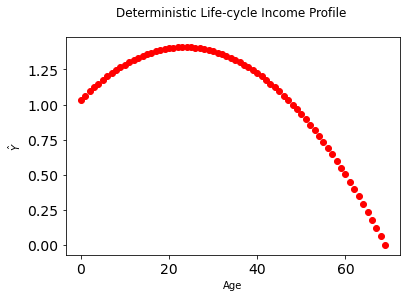

In [10]:
## a deterministic income profile 

plt.title('Deterministic Life-cycle Income Profile \n')
plt.plot(YPath,'ro')
plt.xlabel('Age')
plt.ylabel(r'$\hat Y$')

### Solve the model with a Markov state: unemployment and employment 

In [11]:
## initialize a markov state agent 

lc_mkv = LifeCycle(sigma_n = sigma_n,
                   sigma_eps = sigma_eps,
                   U=U,
                   LivPrb = LivPrb,
                   ρ=ρ,
                   R=R,
                   W=W,
                   G=G,
                   T=T,
                   L=L,
                   β=β,
                   x=x,  ## shut down ma(1)
                   theta=theta,
                   borrowing_cstr = borrowing_cstr,
                   b_y = b_y, ## set the macro state loading to be zero, it does not matter for ue_markov
                   unemp_insurance = unemp_insurance, 
                   pension = pension,
                   ue_markov = ue_markov,
                   sigma_p_init =sigma_p_init,
                   init_b = init_b,
                   λ = λ,
                   transfer = transfer,
                   bequest_ratio = bequest_ratio
                  )

In [12]:
## solve the model 

P = np.array([[0.7,0.3],
            [0.1,0.9]])

## parameterize  
lc_mkv.P = P


## terminal period solutions 
k = len(lc_mkv.s_grid)
k2 =len(lc_mkv.eps_grid)
n = len(lc_mkv.P)

σ_init_mkv = np.empty((k,k2,n))
a_init_mkv = np.empty((k,k2,n))

# terminal solution c = m 
for z in range(n):
    for j in range(k2):
        a_init_mkv[:,j,z] = 2*lc_mkv.s_grid
        σ_init_mkv[:,j,z] = a_init_mkv[:,j,z] 

## solve the model 
as_star_mkv, σs_star_mkv = solve_model_backward_iter(lc_mkv,
                                                 a_init_mkv,
                                                 σ_init_mkv)

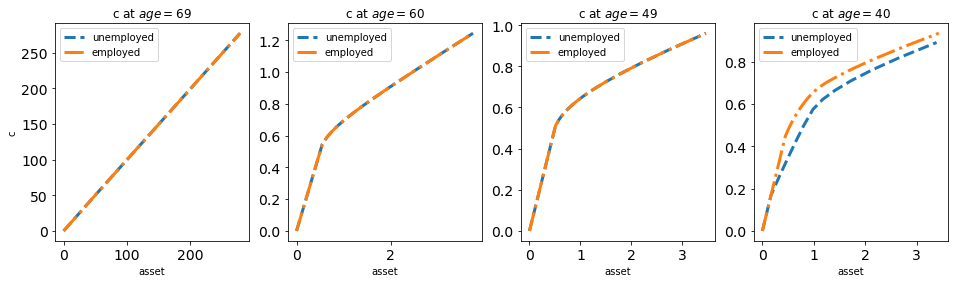

In [13]:
## compare two markov states good versus bad 


years_left = [1,10,21,30]
n_sub = len(years_left)

eps_ls = [10]

fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

for x,year in enumerate(years_left):
    age = lc_mkv.L-year
    i = lc_mkv.L -age
    for y,eps in enumerate(eps_ls):
        axes[x].plot(as_star_mkv[i,:,y,0],
                     σs_star_mkv[i,:,y,0],
                     '--',
                     label ='unemployed',
                     lw=3)
        axes[x].plot(as_star_mkv[i,:,y,1],
                     σs_star_mkv[i,:,y,1],
                     '-.',
                     label ='employed',
                     lw=3)
    axes[x].legend()
    axes[x].set_xlabel('asset')
    axes[0].set_ylabel('c')
    axes[x].set_title(r'c at $age={}$'.format(age))

## Transition matricies

In [14]:
## create distribution grid points 
def define_distribution_grid(model,
                             dist_mGrid = None, 
                             dist_pGrid = None, 
                             m_density = 0, 
                             num_pointsM = 48,  
                             num_pointsP = 50, 
                             max_p_fac = 20.0):
        
        '''
        Defines the grid on which the distribution is defined. Stores the grid of market resources and permanent income as attributes of self.
        Grid for normalized market resources and permanent income may be prespecified 
        as dist_mGrid and dist_pGrid, respectively. If not then default grid is computed based off given parameters.
        
        Parameters
        ----------
        dist_mGrid : np.array
                Prespecified grid for distribution over normalized market resources
            
        dist_pGrid : np.array
                Prespecified grid for distribution over permanent income. 
            
        m_density: float
                Density of normalized market resources grid. Default value is mdensity = 0.
                Only affects grid of market resources if dist_mGrid=None.
            
        num_pointsM: float
                Number of gridpoints for market resources grid.
        
        num_pointsP: float
                 Number of gridpoints for permanent income. 
                 This grid will be exponentiated by the function make_grid_exp_mult.
                
        max_p_fac : float
                Factor that scales the maximum value of permanent income grid. 
                Larger values increases the maximum value of permanent income grid.
        
        Returns
        -------
        List(dist_mGrid): numba typed list, sized of 1, each of which is sized n_m
        List(dist_pGrid): numba typed list, sized of T, each of which is sized n_p
        '''  
 
        ## m distribution grid 
        if dist_mGrid == None:
            aXtra_Grid = make_grid_exp_mult(ming = model.s_grid[0], 
                                            maxg = model.s_grid[-1], 
                                            ng = num_pointsM, 
                                            timestonest = 3) #Generate Market resources grid given density and number of points

            for i in range(m_density):
                axtra_shifted = np.delete(aXtra_Grid,-1) 
                axtra_shifted = np.insert(axtra_shifted, 0,1.00000000e-04)
                dist_betw_pts = aXtra_Grid - axtra_shifted
                dist_betw_pts_half = dist_betw_pts/2
                new_A_grid = axtra_shifted + dist_betw_pts_half
                aXtra_Grid = np.concatenate((aXtra_Grid,new_A_grid))
                aXtra_Grid = np.sort(aXtra_Grid)
                
            dist_mGrid =  [aXtra_Grid]

        else:
            dist_mGrid = [dist_mGrid] #If grid of market resources prespecified then use as mgrid
            
        ## permanent distribution grid 
        if dist_pGrid == None:
            dist_pGrid = [] #list of grids of permanent income    

            for i in range(model.L):
                #Dist_pGrid is taken to cover most of the ergodic distribution
                if model.sigma_n!=0.0:
                    std_p = model.sigma_n
                else:
                    std_p = 1e-2
                max_p = max_p_fac*std_p*(1/(1-model.LivPrb))**0.5 # Consider probability of staying alive this period
                right_sided_grid = make_grid_exp_mult(1.0+1e-3, np.exp(max_p), num_pointsP, 2)
                left_sided_gird = np.append(1.0/np.fliplr([right_sided_grid])[0],np.ones(1))
                left_sided_gird = 1.0/np.fliplr([right_sided_grid])[0]
                this_dist_pGrid = np.append(left_sided_gird,
                                            right_sided_grid) # Compute permanent income grid this period. Grid of permanent income may differ dependent on PermShkStd
                dist_pGrid.append(this_dist_pGrid)
              
        else:
            dist_pGrid = [dist_pGrid] #If grid of permanent income prespecified then use as pgrid
            
        return List(dist_mGrid), List(dist_pGrid)

In [15]:
@njit
def jump_to_grid(model, 
                 m_vals, 
                 perm_vals, 
                 probs, 
                 dist_mGrid, 
                 dist_pGrid):

    '''
    Distributes values onto a predefined grid, maintaining the means. m_vals and perm_vals are realizations of market resources and permanent income while 
    dist_mGrid and dist_pGrid are the predefined grids of market resources and permanent income, respectively. That is, m_vals and perm_vals do not necesarily lie on their 
    respective grids. Returns probabilities of each gridpoint on the combined grid of market resources and permanent income.


    Parameters
    ----------
    m_vals: np.array
            Market resource values 

    perm_vals: np.array
            Permanent income values 

    probs: np.array
            Shock probabilities associated with combinations of m_vals and perm_vals. 
            Can be thought of as the probability mass function  of (m_vals, perm_vals).

    dist_mGrid : np.array
            Grid over normalized market resources

    dist_pGrid : np.array
            Grid over permanent income 

    Returns
    -------
    probGrid.flatten(): np.array
             Probabilities of each gridpoint on the combined grid of market resources and permanent income
    '''

    probGrid = np.zeros((len(dist_mGrid),len(dist_pGrid)))
    mIndex = np.digitize(m_vals,dist_mGrid) - 1 # Array indicating in which bin each values of m_vals lies in relative to dist_mGrid. Bins lie between between point of Dist_mGrid. 
    #For instance, if mval lies between dist_mGrid[4] and dist_mGrid[5] it is in bin 4 (would be 5 if 1 was not subtracted in the previous line). 
    mIndex[m_vals <= dist_mGrid[0]] = -1 # if the value is less than the smallest value on dist_mGrid assign it an index of -1
    mIndex[m_vals >= dist_mGrid[-1]] = len(dist_mGrid)-1 # if value if greater than largest value on dist_mGrid assign it an index of the length of the grid minus 1

    #the following three lines hold the same intuition as above
    pIndex = np.digitize(perm_vals,dist_pGrid) - 1
    pIndex[perm_vals <= dist_pGrid[0]] = -1
    pIndex[perm_vals >= dist_pGrid[-1]] = len(dist_pGrid)-1

    for i in range(len(m_vals)):
        if mIndex[i]==-1: # if mval is below smallest gridpoint, then assign it a weight of 1.0 for lower weight. 
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i]==len(dist_mGrid)-1: # if mval is greater than maximum gridpoint, then assign the following weights
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else: # Standard case where mval does not lie past any extremes
        #identify which two points on the grid the mval is inbetween
            mlowerIndex = mIndex[i] 
            mupperIndex = mIndex[i]+1
        #Assign weight to the indices that bound the m_vals point. Intuitively, an mval perfectly between two points on the mgrid will assign a weight of .5 to the gridpoint above and below
            mlowerWeight = (dist_mGrid[mupperIndex]-m_vals[i])/(dist_mGrid[mupperIndex]-dist_mGrid[mlowerIndex]) #Metric to determine weight of gridpoint/index below. Intuitively, mvals that are close to gridpoint/index above are assigned a smaller mlowerweight.
            mupperWeight = 1.0 - mlowerWeight # weight of gridpoint/ index above

        #Same logic as above except the weights here concern the permanent income grid
        if pIndex[i]==-1: 
            plowerIndex = 0
            pupperIndex = 0
            plowerWeight = 1.0
            pupperWeight = 0.0
        elif pIndex[i]==len(dist_pGrid)-1:
            plowerIndex = -1
            pupperIndex = -1
            plowerWeight = 1.0
            pupperWeight = 0.0
        else:
            plowerIndex = pIndex[i]
            pupperIndex = pIndex[i]+1
            plowerWeight = (dist_pGrid[pupperIndex]-perm_vals[i])/(dist_pGrid[pupperIndex]-dist_pGrid[plowerIndex])
            pupperWeight = 1.0 - plowerWeight

        # Compute probabilities of each gridpoint on the combined market resources and permanent income grid by looping through each point on the combined market resources and permanent income grid, 
        # assigning probabilities to each gridpoint based off the probabilities of the surrounding mvals and pvals and their respective weights placed on the gridpoint.
        # Note* probs[i] is the probability of mval AND pval occurring
        probGrid[mlowerIndex][plowerIndex] = probGrid[mlowerIndex][plowerIndex] + probs[i]*mlowerWeight*plowerWeight # probability of gridpoint below mval and pval 
        probGrid[mlowerIndex][pupperIndex] = probGrid[mlowerIndex][pupperIndex] + probs[i]*mlowerWeight*pupperWeight # probability of gridpoint below mval and above pval
        probGrid[mupperIndex][plowerIndex] = probGrid[mupperIndex][plowerIndex] + probs[i]*mupperWeight*plowerWeight # probability of gridpoint above mval and below pval
        probGrid[mupperIndex][pupperIndex] = probGrid[mupperIndex][pupperIndex] + probs[i]*mupperWeight*pupperWeight # probability of gridpoint above mval and above pval

    return probGrid.flatten()

@njit
def jump_to_grid_fast(model, 
                      vals, 
                      probs,
                      Grid ):
    '''
    Distributes values onto a predefined grid, maintaining the means.
    ''' 

    probGrid = np.zeros(len(Grid))
    mIndex = np.digitize(vals,Grid) - 1
    # return the indices of the bins to which each value in input array belongs.
    mIndex[vals <= Grid[0]] = -1
    mIndex[vals >= Grid[-1]] = len(Grid)-1


    for i in range(len(vals)):
        if mIndex[i]==-1:
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i]==len(Grid)-1:
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else:
            mlowerIndex = mIndex[i]
            mupperIndex = mIndex[i]+1
            mlowerWeight = (Grid[mupperIndex]-vals[i])/(Grid[mupperIndex] - Grid[mlowerIndex])
            mupperWeight = 1.0 - mlowerWeight

        probGrid[mlowerIndex] = probGrid[mlowerIndex] + probs[i]*mlowerWeight
        probGrid[mupperIndex] = probGrid[mupperIndex] + probs[i]*mupperWeight

    return probGrid.flatten()

In [16]:
## testing define distribution grid 

n_m = 40
n_p = 50

m_dist_grid_list,p_dist_grid_list = define_distribution_grid(lc_mkv,
                                                             num_pointsM = n_m,
                                                             num_pointsP = n_p)
fix_epsGrid  = 0.0   ## Without ma shock, consumption does not depend on transitory shock                                           

In [17]:
## Markov transition matrix 

print("markov state transition matrix: \n",lc_mkv.P)

ss_dstn = cal_ss_2markov(lc_mkv.P)

print('steady state of markov state:\n',ss_dstn)

markov state transition matrix: 
 [[0.7 0.3]
 [0.1 0.9]]
steady state of markov state:
 [0.25 0.75]


In [18]:
## compute the list of transition matrix from age t to t+1 for all age 

@njit
def calc_transition_matrix(model, 
                           as_star, ## new,  life cycle age x asset x tran shock x z state grid 
                           σs_star, ## new, life cycle consumptiona t age  x asset x tran shock x z state grid 
                           dist_mGrid_list, ## new, list, grid of m for distribution 
                           dist_pGrid_list,  ## new, list, grid of p for distribution 
                           finite_horizon = True, ## new 
                           fast = True   ## new 
                          ):
        '''
        Calculates how the distribution of agents across market resources 
        transitions from one period to the next. 
        If finite horizon problem, then calculates
        a list of transition matrices, consumption and asset policy grids for each period of the problem. 
        
        
        Parameters
        ----------
            # as_star: array, sized of T x n_a x n_eps x n_z, asset grid 
            # σs_star: array, sized of T x n_a x n_eps x n_z, consumption values at the grid
            # dist_mGrid_list, list, sized of 1, list of m grid sized of n_m
            # dist_pGrid_list, list, sized of T, list of permanent income grid for each age, sized of n_p
            # finite_horizon, bool, True if life cycle is used 
            # fast, bool, fast or slow method 

        Returns
        -------
            # tran_matrix_list, numba typed list, embedded list, sized of n_z,
            ## each of which is sized of T, each of which is sized of n_m x n_p 
        
        ''' 
        
        ## nb of states 
        state_num = len(model.P)
        
        ## unemployment insurance 
        unemp_insurance = model.unemp_insurance
        
        ## tax rate
        λ = model.λ
        
        ## grid holders
        cPol_Grid_e_list = [] # List of consumption policy grids for each period in T_cycle
        cPol_Grid_u_list = [] # List of consumption policy grids for each period in T_cycle

        aPol_Grid_e_list = [] # List of asset policy grids for each period in T_cycle
        aPol_Grid_u_list = [] # List of asset policy grids for each period in T_cycle
        
        

        tran_matrix_e_list = [] # List of transition matrices
        tran_matrix_u_list = [] # List of transition matrices

        for k in range(model.L): ## loop over agents at different ages 
            
            year_left = model.L-(k+1)
            
            
            markov_array2 = model.P

            if finite_horizon==True:
                this_dist_pGrid = dist_pGrid_list[k] #Permanent income grid this period
            else:
                this_dist_pGrid = dist_pGrid_list[0] #If here then use prespecified permanent income grid
            
            ## m-grid does not depend on period 
            
            this_dist_mGrid = dist_mGrid_list[0]
        
            
            ## compute different c at different a and eps
            
            n_mgrid = len(this_dist_mGrid)
            
            Cnow_u= np.empty(n_mgrid,dtype = np.float64)
            Cnow_e = np.empty(n_mgrid,dtype = np.float64)

            fix_epsGrid = 1.0
            
            for m_id,m in enumerate(this_dist_mGrid):
                this_Cnow_u = mlinterp((as_star[year_left,:,0,0],   
                                        model.eps_grid),
                                       σs_star[year_left,:,:,0],
                                       (m,fix_epsGrid))
                Cnow_u[m_id] = this_Cnow_u
                
                #Cnow_u_list.append(this_Cnow_u)
                this_Cnow_e = mlinterp((as_star[year_left,:,0,1],
                                        model.eps_grid),
                                       σs_star[year_left,:,:,1],
                                       (m,fix_epsGrid))
                Cnow_e[m_id] = this_Cnow_e
                #Cnow_e_list.append(this_Cnow_e)
                
            
            ## more generally, depending on the nb of markov states 
            
            #Cnow_e = self.solution[k].cFunc[0](dist_mGrid)  #Consumption policy grid in period k
            #Cnow_u = self.solution[k].cFunc[1](dist_mGrid) 


            cPol_Grid_u_list.append(Cnow_u)  # List of consumption policy grids for each age
            cPol_Grid_e_list.append(Cnow_e)  # List of consumption policy grids for each age

            aNext_u = this_dist_mGrid - Cnow_u # Asset policy grid in each age
            aNext_e = this_dist_mGrid - Cnow_e # Asset policy grid in each age
            
            aPol_Grid_u_list.append(aNext_u) # Add to list
            aPol_Grid_e_list.append(aNext_e) # Add to list


            #if finite_horizon==True:
            #    bNext_u = model.R[k][0]*aNext_u # we chose the index zero because it both agents face the same interest rate
            #    bNext_e = model.R[k][0]*aNext_e
            #else:
            bNext_u = model.R*aNext_u
            bNext_e = model.R*aNext_e


            #Obtain shocks and shock probabilities from income distribution this period
            size_shk_probs  = model.shock_draw_size**2
            shk_prbs = np.ones(size_shk_probs)*1/size_shk_probs
            tran_shks = np.exp(np.repeat(model.eps_shk_draws,
                                  model.shock_draw_size))
            perm_shks = np.exp(np.repeat(model.n_shk_draws,
                                  model.shock_draw_size))
            
            ## This is for the fast method 
            shk_prbs_ntrl =  np.multiply(shk_prbs,perm_shks)
            ## not used yet 
                        
            #shk_prbs = shk_dstn[k][0].pmf  #Probability of shocks this period , 
            ## I choose the index zero, because we really only use the employe dshock distribution, the unemployed is already implemented automatically
            #tran_shks = shk_dstn[k][0].X[1] #Transitory shocks this period
            #perm_shks = shk_dstn[k][0].X[0] #Permanent shocks this period
            #LivPrb = self.LivPrb[k][0] # Update probability of staying alive this period

            
            if fast==True:  

            
                # Generate Transition Matrix for u2u
                TranMatrix_uu = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid))) 
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+(1-λ)*unemp_insurance 
                    else:
                        ## retirement 
                        mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+model.pension/perm_shks
                    # Compute next period's market resources given todays bank balances bnext[i]
                    TranMatrix_uu[:,i] = jump_to_grid_fast(model,
                                                           mNext_ij,
                                                           shk_prbs,
                                                           this_dist_mGrid) 

                # Generate Transition Matrix for u2e
                TranMatrix_ue = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid))) 
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+ (1-λ)*tran_shks  
                    else:
                        ## retirement 
                        mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+model.pension/perm_shks
                    # Compute next period's market resources given todays bank balances bnext[i]
                    TranMatrix_ue[:,i] = jump_to_grid_fast(model,
                                                            mNext_ij,
                                                            shk_prbs,
                                                            this_dist_mGrid) 
                

                # Generate Transition Matrix for e2e 
                TranMatrix_ee = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid))) 
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+ (1-λ)*tran_shks # Compute next period's market resources given todays bank balances bnext[i]
                    else:
                        ## retirement 
                        mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+model.pension/perm_shks
                    TranMatrix_ee[:,i] = jump_to_grid_fast(model,
                                                          mNext_ij,
                                                          shk_prbs,
                                                          this_dist_mGrid)

                # Generate Transition Matrix for e2u 
                TranMatrix_eu = np.zeros((len(this_dist_mGrid),
                                          len(this_dist_mGrid))) 
                for i in range(len(this_dist_mGrid)):
                    if k <=model.T-1:
                        ## work age 
                        mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+ (1-λ)*unemp_insurance # Compute next period's market resources given todays bank balances bnext[i]
                    else:
                        mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+ model.pension/perm_shks
                    TranMatrix_eu[:,i] = jump_to_grid_fast(model,
                                                            mNext_ij, 
                                                            shk_prbs,
                                                            this_dist_mGrid) 


            else:  ## slow method  (Markov implemented as well)


                # Generate Transition Matrix for u2u 
                TranMatrix_uu = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            ## work age 
                            mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+ (1-λ)*unemp_insurance # Compute next period's market resources given todays bank balances bnext[i]
                        else:
                            mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+ model.pension/perm_shks

                        TranMatrix_uu[:,i*len(this_dist_pGrid)+j] = jump_to_grid(model,
                                                                                 mNext_ij,
                                                                                 pNext_ij,
                                                                                 shk_prbs,
                                                                                 this_dist_mGrid, 
                                                                                this_dist_pGrid) 
                #TranMatrix = TranMatrix #columns represent the current state while rows represent the next state
                #the 4th row , 6th column entry represents the probability of transitioning from the 6th element of the combined perm and m grid (grid of market resources multiplied by grid of perm income) to the 4th element of the combined perm and m grid
                #tran_matrix_list.append(TranMatrix_uu)   
                
    
                # Generate Transition Matrix for u2e 
                TranMatrix_ue = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            ## work age 
                            mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+ (1-λ)*tran_shks # Compute next period's market resources given todays bank balances bnext[i]
                        else:
                            mNext_ij = bNext_u[i]/perm_shks +model.transfer/perm_shks+ model.pension/perm_shks
                        TranMatrix_ue[:,i*len(this_dist_pGrid)+j] = jump_to_grid(model,
                                                                               mNext_ij, 
                                                                               pNext_ij, 
                                                                               shk_prbs, 
                                                                               this_dist_mGrid, 
                                                                               this_dist_pGrid) 
                        
                # Generate Transition Matrix for e2u 
                TranMatrix_eu = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks # Computes next period's permanent income level by applying permanent income shock

                        if k <=model.T-1:
                            ## work age 
                            mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+ (1-λ)*unemp_insurance # Compute next period's market resources given todays bank balances bnext[i]
                        else:
                            mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+ model.pension/perm_shks
                        TranMatrix_eu[:,i*len(this_dist_pGrid)+j] = jump_to_grid(model,
                                                                                   mNext_ij, 
                                                                                   pNext_ij, 
                                                                                   shk_prbs, 
                                                                                   this_dist_mGrid, 
                                                                                   this_dist_pGrid) 
                        
                # Generate Transition Matrix for e2e 
                TranMatrix_ee = np.zeros((len(this_dist_mGrid)*len(this_dist_pGrid),
                                       len(this_dist_mGrid)*len(this_dist_pGrid))) 
                
                for i in range(len(this_dist_mGrid)):
                    for j in range(len(this_dist_pGrid)):
                        pNext_ij = this_dist_pGrid[j]*perm_shks # Computes next period's permanent income level by applying permanent income shock
                        if k <=model.T-1:
                            mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+(1-λ)*tran_shks # Compute next period's market resources given todays bank balances bnext[i]
                        else:
                            mNext_ij = bNext_e[i]/perm_shks +model.transfer/perm_shks+model.pension/perm_shks
                        TranMatrix_ee[:,i*len(this_dist_pGrid)+j] = jump_to_grid(model,
                                                                               mNext_ij, 
                                                                               pNext_ij, 
                                                                               shk_prbs, 
                                                                               this_dist_mGrid, 
                                                                               this_dist_pGrid) 

                        
        ###################################################
        ## back from the fork between slow and fast method 
        ##################################################
        ## transition matrix for each markov state 
            tran_matrix_u = markov_array2[0,1] * TranMatrix_ue  + markov_array2[0,0]* TranMatrix_uu #This is the transition for someone who's state today is unemployed
            tran_matrix_e = markov_array2[1,1]*TranMatrix_ee  +  markov_array2[1,0] * TranMatrix_eu # This is the transition for someone who's state is employed today

                
            ## merge to the life cycle list 
            tran_matrix_u_list.append( tran_matrix_u ) #This is the transition for someone who's state today is unemployed
            tran_matrix_e_list.append( tran_matrix_e )
            
            
            # fraction of people who are in different markov states 
            #prb_emp = dstn_0[0] 
            #prb_unemp = 1 - prb_emp 

            #prb_emp_list.append(prb_emp)
            #prb_unemp_list.append(prb_unemp)
                            
            #tran_matrix_combined =  prb_unemp * tran_matrix_u + prb_emp * tran_matrix_e # This is the transition matrix for the whole economy
            #tran_matrix_list.append(tran_matrix_combined)
                
            ## move markov state to the next period
            #dstn_0 = np.dot(dstn_0,markov_array2)
                
        tran_matrix_list = List([tran_matrix_u_list,
                                 tran_matrix_e_list])
        
        ## return aggregate transition matrix and 
        ###.   the age/state dependent transition matricies necessary for computing aggregate consumption 
        
        
        ## consumption policy and saving grid on each m, p, z and k grid 
        cPol_Grid_list = List([cPol_Grid_u_list,
                               cPol_Grid_e_list])  # List of consumption policy grids for each period in T_cycle
        aPol_Grid_list = List([aPol_Grid_u_list,
                               aPol_Grid_e_list]) ## list of consumption 
        
        
        return tran_matrix_list, cPol_Grid_list,aPol_Grid_list

In [19]:
@njit
def initial_distribution_u(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    size_shk_probs  = model.shock_draw_size**2
    λ = model.λ
    init_b = model.init_b
    shk_prbs = np.ones(size_shk_probs)*1/size_shk_probs
    ue_insurance = np.repeat(np.ones_like(model.eps_shk_draws),
                          model.shock_draw_size)*model.unemp_insurance  
    init_p_draws = np.exp(np.repeat(model.init_p_draws,
                          model.shock_draw_size))
    
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid(model,
                               np.ones_like(init_p_draws)*((1-λ)*ue_insurance+init_b/init_p_draws+model.transfer), ## initial unemployment insurance and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

@njit
def initial_distribution_e(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    size_shk_probs  = model.shock_draw_size**2
    λ = model.λ
    λ_SS = model.λ_SS
    init_b = model.init_b
    shk_prbs = np.ones(size_shk_probs)*1/size_shk_probs
    tran_shks = np.exp(np.repeat(model.eps_shk_draws,
                          model.shock_draw_size))
    init_p_draws = np.exp(np.repeat(model.init_p_draws,
                          model.shock_draw_size))
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid(model,
                              (1-λ)*(1-λ_SS)*tran_shks+init_b/init_p_draws+model.transfer, ## initial transitory risks and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

In [20]:
## plot the initial distribution in the first period of life 
initial_dist_u = initial_distribution_u(lc_mkv,
                                      m_dist_grid_list[0],
                                      p_dist_grid_list[0])

initial_dist_e = initial_distribution_e(lc_mkv,
                                      m_dist_grid_list[0],
                                      p_dist_grid_list[0])

Text(0, 0.5, 'm')

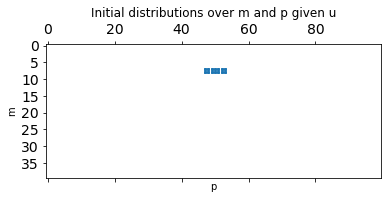

In [21]:
## plot the initial distribution in the first period of life 

plt.title('Initial distributions over m and p given u')
plt.spy(initial_dist_u.reshape(n_m,-1),
       markersize = 2)
plt.xlabel('p')
plt.ylabel('m')

Text(0, 0.5, 'm')

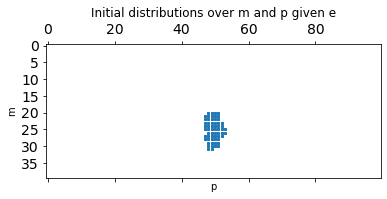

In [22]:
## plot the initial distribution in the first period of life 

plt.title('Initial distributions over m and p given e')
plt.spy(initial_dist_e.reshape(n_m,-1),
       markersize = 2)
plt.xlabel('p')
plt.ylabel('m')

In [23]:
## These two functions have no use for life cycle models 
@njit
def aggregate_transition_matrix(model,
                                tran_matrix_lists,  ## size model.T 
                                dstn_0,    ## size n.z
                                age_dist): ## size model.T 
    ## aggregate different ages in the population
    n1,n2 = tran_matrix_lists[0][0].shape
    trans_matrix_agg = np.zeros((n1,n2),
                                dtype=np.float64)
    for z in range(len(dstn_0)):
        for k in range(model.L):
            trans_matrix_agg = trans_matrix_agg+dstn_0[z]*age_dist[k]*tran_matrix_lists[z][k] 
    return trans_matrix_agg

## for any transition matrix, compute the ergodic distribution 

def calc_ergodic_dist(transition_matrix = None):

    '''
    Calculates the ergodic distribution for the transition_matrix, 
    here it is the distribution (before being reshaped) over normalized market resources and
    permanent income as the eigenvector associated with the eigenvalue 1.
    

    Parameters
    ----------
    transition_matrix: array 
                transition matrix whose ergordic distribution is to be solved

    Returns
    -------
    ergodic_distr: a vector array 
    The distribution is stored as a vector 
    ## reshaping it to (n_m, n_p) gives a reshaped array with the ij'th element representing
    the probability of being at the i'th point on the mGrid and the j'th
    point on the pGrid.
    '''

    #if transition_matrix == None:
    #    #transition_matrix = [self.tran_matrix]
    #    print('needs transition_matrix')
    
    eigen, ergodic_distr = sp.linalg.eigs(transition_matrix , k=1 , which='LM')  # Solve for ergodic distribution
    ergodic_distr = ergodic_distr.real/np.sum(ergodic_distr.real)   

    #vec_erg_dstn = ergodic_distr #distribution as a vector
    #erg_dstn = ergodic_distr.reshape((len(m_dist_grid_list[0]),
    #                                  len(p_dist_grid_list[0]))) # distribution reshaped into len(mgrid) by len(pgrid) array
    return ergodic_distr 

In [24]:
## get the stationary age distribution 
@njit
def stationary_age_dist(L,
                        n,
                       LivPrb):
    """
    stationary age distribution of the economy given 
    T: nb of periods of life 
    n: Population growth rate 
    ProbLiv: survival probability 
    """
    cum = 0.0
    for i in range(L):
        cum = cum + LivPrb**i/(1+n)
    sigma1 = 1/cum
    
    dist = np.empty(L)
    
    for i in range(L):
        dist[i] = sigma1*LivPrb**i/(1+n)
    return dist 

In [25]:
## get the distributions of each age by iterating forward over life cycle 

def SSDist(model,
          as_star,
          σs_star,
          m_dist_grid_list,
          p_dist_grid_list):
    
    time_start = time()
    
    
    ## get the embedded list sized n_z x T x n_m x n_p

    tran_matrix_lists,c_PolGrid_list,a_PolGrid_list = calc_transition_matrix(model,
                                                                             as_star, ## 
                                                                             σs_star,
                                                                             m_dist_grid_list,
                                                                             p_dist_grid_list,
                                                                            fast = False)
    
    
    ## plot the initial distribution in the first period of life 
    initial_dist_u = initial_distribution_u(model,
                                          m_dist_grid_list[0],
                                          p_dist_grid_list[0])

    initial_dist_e = initial_distribution_e(model,
                                            m_dist_grid_list[0],
                                            p_dist_grid_list[0])
    
    ## iterate forward 
    
    n_m = len(m_dist_grid_list[0])
    

    dist_u_lists = []
    dist_e_lists = []
    dist_u_lists.append(initial_dist_u)
    dist_e_lists.append(initial_dist_e)


    mp_pdfs_lists_u_2d = []
    mp_pdfs_lists_e_2d = []
    mp_pdfs_lists_u_2d.append(initial_dist_u.reshape(n_m,-1))
    mp_pdfs_lists_e_2d.append(initial_dist_e.reshape(n_m,-1))

    mp_pdfs_lists_u = []
    mp_pdfs_lists_e = []
    mp_pdfs_lists_u.append(initial_dist_u.reshape(n_m,-1).sum(axis=1))
    mp_pdfs_lists_e.append(initial_dist_e.reshape(n_m,-1).sum(axis=1))
    

    ## policy grid lists 
    cp_u_PolGrid_list = []
    cp_e_PolGrid_list = []
    ap_u_PolGrid_list = []
    ap_e_PolGrid_list = []


    ## m/p distribution in the first period in life (newborns)
    this_dist_u = initial_dist_u
    this_dist_e = initial_dist_e


    ## iterate forward for all periods in life 
    for k in range(model.L-1):
        ## uemp 
        this_dist_u = np.matmul(tran_matrix_lists[0][k],
                                this_dist_u)
        dist_u_lists.append(this_dist_u)

        this_dist_u_2d = this_dist_u.reshape(n_m,-1)
        mp_pdfs_lists_u_2d.append(this_dist_u_2d)

        this_dist_u_2d_marginal = this_dist_u_2d.sum(axis=1)
        mp_pdfs_lists_u.append(this_dist_u_2d_marginal)

        ##emp
        this_dist_e = np.matmul(tran_matrix_lists[1][k],
                                 this_dist_e)
        dist_e_lists.append(this_dist_e)
        this_dist_e_2d = this_dist_e.reshape(n_m,-1)
        mp_pdfs_lists_e_2d.append(this_dist_e_2d)

        this_dist_e_2d_marginal = this_dist_e_2d.sum(axis=1)
        mp_pdfs_lists_e.append(this_dist_e_2d_marginal)
    
    for k in range(model.L):
           
        ## c and a for u 
        cp_PolGrid = np.multiply.outer(c_PolGrid_list[0][k],
                                       p_dist_grid_list[k])
        cp_u_PolGrid_list.append(cp_PolGrid)

        ap_PolGrid = np.multiply.outer(a_PolGrid_list[0][k],
                                       p_dist_grid_list[k])
        ap_u_PolGrid_list.append(ap_PolGrid)

        ## c and a for e 
        cp_PolGrid = np.multiply.outer(c_PolGrid_list[1][k],
                                       p_dist_grid_list[k])
        cp_e_PolGrid_list.append(cp_PolGrid)


        ap_PolGrid = np.multiply.outer(a_PolGrid_list[1][k],
                                       p_dist_grid_list[k])
        ap_e_PolGrid_list.append(ap_PolGrid)

    ## stack the distribution lists 
    dist_lists = [dist_u_lists,
                 dist_e_lists]

    ##  joint pdfs over m and p
    mp_pdfs_2d_lists = [mp_pdfs_lists_u_2d,
                       mp_pdfs_lists_e_2d]

    ## marginalized pdfs over m 
    mp_pdfs_lists = [mp_pdfs_lists_u,
                     mp_pdfs_lists_e]  ## size of n_z x model.T


    ## c policy grid 
    cp_PolGrid_list = [cp_u_PolGrid_list,
                      cp_e_PolGrid_list]

    # a policy grid 

    ap_PolGrid_list = [ap_u_PolGrid_list,
                      ap_e_PolGrid_list]


    time_end = time()
    print('time taken:'+str(time_end-time_start))
    
    return tran_matrix_lists,dist_lists,mp_pdfs_2d_lists,mp_pdfs_lists,cp_PolGrid_list,ap_PolGrid_list

In [26]:
## get the transition matrix and policy grid 

tran_matrix_lists, dist_lists,mp_pdfs_2d_lists,mp_pdfs_lists,cp_PolGrid_list,ap_PolGrid_list = SSDist(lc_mkv,
                                                                                                      as_star_mkv,
                                                                                                      σs_star_mkv,
                                                                                                      m_dist_grid_list,
                                                                                                      p_dist_grid_list)

time taken:81.92713189125061


In [27]:
## stationary age distribution 

age_dist = stationary_age_dist(lc_mkv.L,
                               n = 0.0,
                               LivPrb =lc_mkv.LivPrb)

Text(0, 0.5, 'p x m')

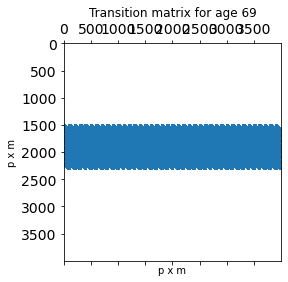

In [28]:
## examine some of the transitionary matricies 
age = L
plt.title('Transition matrix for age '+str(age-1))
plt.spy(tran_matrix_lists[1][age-1],
       #precision=0.1, 
        markersize = 2
       )
plt.xlabel('p x m')
plt.ylabel('p x m')

In [29]:
### Aggregate C or A

def Aggregate(dist_lists,   ## size of nb markov state, each of which is sized model.T, each of which is sized n_m x n_p
              mp_pdfs_lists,  ## list of pdfs of over m and p grids given markov state and age
              dstn_0, 
              age_dist):      ## distribution over ages
    X = 0.0
    for z in range(len(dstn_0)):
        for k in range(len(age_dist)):
            x_flat = dist_lists[z][k].flatten()
            pdf_flat = mp_pdfs_lists[z][k].flatten()
            X+= np.dot(x_flat,pdf_flat)*age_dist[k]*dstn_0[z]
    return X

In [30]:
## compute aggregate C 

C = Aggregate(cp_PolGrid_list,
              mp_pdfs_2d_lists,
              ss_dstn,
              age_dist)

A = Aggregate(ap_PolGrid_list,
              mp_pdfs_2d_lists,
              ss_dstn,
              age_dist)


In [31]:
print('aggregate consumption under stationary distribution:', str(C))
print('aggregate savings under stationary distribution:', str(A))

aggregate consumption under stationary distribution: 2.0823151214151765
aggregate savings under stationary distribution: 1.5856524183992178


### Stationary wealth/consumption distribution

In [32]:
## get the single vector of distribution 

def faltten_dist(grid_lists,      ## nb.z x T x nb x nm x np 
                 mp_pdfs_lists,   ## nb.z x T x nb x nm x np 
                 dstn,            ## size of nb.z 
                 age_dist):       ## size of T 
    mp_pdfs_lists_new = []
    for z in range(len(dstn)):
        for k in range(len(age_dist)):
            this_pdfs_lists = mp_pdfs_lists[z][k]*dstn[z]*age_dist[k]
            mp_pdfs_lists_new.append(this_pdfs_lists)
            
    grid_sort_id = np.array(grid_lists).flatten().argsort()
    grid_array = np.array(grid_lists).flatten()[grid_sort_id]
    mp_pdfs_array = np.array(mp_pdfs_lists_new).flatten()[grid_sort_id]
    
    return grid_array, mp_pdfs_array

In [33]:
## flatten the distribution of a and its corresponding pdfs 


ap_grid_dist, ap_pdfs_dist = faltten_dist(ap_PolGrid_list,
                                        mp_pdfs_2d_lists,
                                        ss_dstn,
                                        age_dist)


cp_grid_dist, cp_pdfs_dist = faltten_dist(cp_PolGrid_list,
                                        mp_pdfs_2d_lists,
                                        ss_dstn,
                                        age_dist)

In [34]:
## lorenz curve
def lorenz_curve(grid_distribution,
                 pdfs,
                 nb_share_grid = 50):
    """
    parameters
    ======
    grid_distribution: grid on which distribution is defined
    pdfs: the fractions/pdfs of each grid ranges 
    
    return
    ======
    lc_vals: the fraction of people corresponding whose total wealth reaches the corresponding share, x axis in lorenz curve
    share_grids: different grid points of the share of total wealth, y axis in lorenz curve
    """
    total = np.dot(grid_distribution,pdfs)
    share_grids = np.linspace(0.0,0.99,nb_share_grid)
    share_cum = np.multiply(grid_distribution,pdfs).cumsum()/total
    lc_vals = []
    for i,share in enumerate(share_grids):
        where = min([x for x in range(len(share_cum)) if share_cum[x]>=share])
        this_lc_val = pdfs[0:where].sum()
        lc_vals.append(this_lc_val)
    return np.array(lc_vals),share_grids

In [35]:
## compute things needed for lorenz curve plot of asset accumulation 

share_agents_cp, share_cp = lorenz_curve(cp_grid_dist,
                                     cp_pdfs_dist,
                                     nb_share_grid = 100)

## compute things needed for lorenz curve plot of asset accumulation 

share_agents_ap, share_ap = lorenz_curve(ap_grid_dist,
                                     ap_pdfs_dist,
                                     nb_share_grid = 100)

(0.0, 1.0)

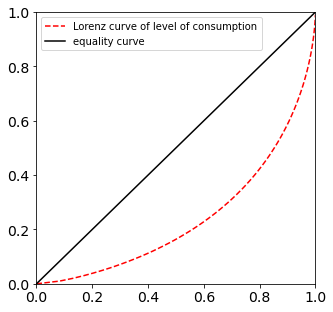

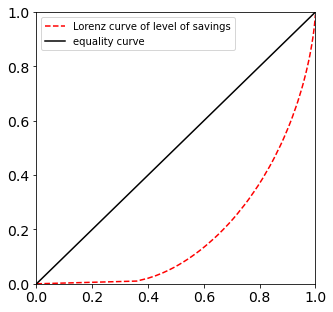

In [36]:
## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(share_agents_cp,share_cp, 'r--',label='Lorenz curve of level of consumption')
ax.plot(share_agents_cp,share_agents_cp, 'k-',label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])


## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(share_agents_ap,share_ap, 'r--',label='Lorenz curve of level of savings')
ax.plot(share_agents_ap,share_agents_ap, 'k-',label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_44509/1298611280.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ap_grid_dist+0.0000000001),


Text(0, 0.5, '$prob(a)$')

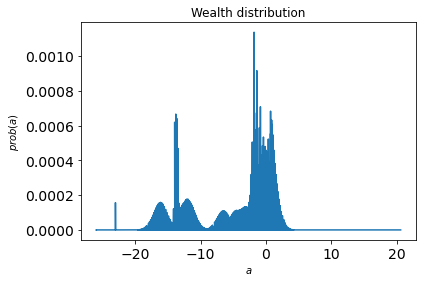

In [37]:
## Wealth distribution 

plt.title('Wealth distribution')
plt.plot(np.log(ap_grid_dist+0.0000000001), 
         ap_pdfs_dist)
plt.xlabel(r'$a$')
plt.ylabel(r'$prob(a)$')

Text(0, 0.5, '$prob(a)$')

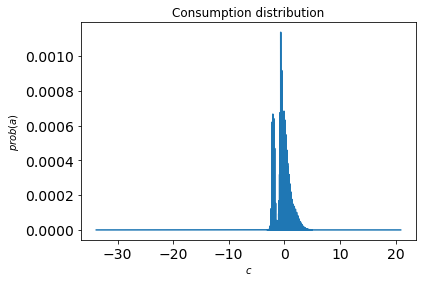

In [38]:
plt.title('Consumption distribution')
plt.plot(np.log(cp_grid_dist), 
         cp_pdfs_dist)
plt.xlabel(r'$c$')
plt.ylabel(r'$prob(a)$')

### Life-cycle profile and distribution

In [39]:
### Aggregate distributions within age

C_life = []
A_life = []


for t in range(L):
    age_dist_sparse = np.zeros(L)
    age_dist_sparse[t] = 1.0
    
    ## age specific wealth 
    C_this_age = Aggregate(cp_PolGrid_list,
              mp_pdfs_2d_lists,
              ss_dstn,
              age_dist_sparse)
    
    C_life.append(C_this_age)

    A_this_age = Aggregate(ap_PolGrid_list,
                          mp_pdfs_2d_lists,
                          ss_dstn,
                          age_dist_sparse)
    
    A_life.append(A_this_age)

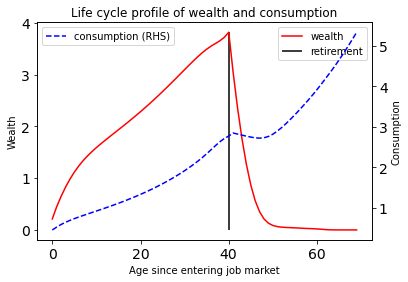

In [40]:
## plot life cycle profile

fig, ax = plt.subplots()
plt.title('Life cycle profile of wealth and consumption')
ax.plot(range(L),
        A_life,
       'r-',
       label='wealth')
ax.vlines(T,
          np.min(A_life),
          np.max(A_life),
          color='k',
          label='retirement')
ax2= ax.twinx()
ax2.plot(range(L),
        C_life,
        'b--',
        label='consumption (RHS)')

ax.set_xlabel('Age since entering job market')
ax.set_ylabel('Wealth')
ax2.set_ylabel('Consumption')
ax.legend(loc=1)
ax2.legend(loc=2)

In [41]:
### Distribution over life cycle 

## Flatten distribution by age

ap_grid_dist_life = []
ap_pdfs_dist_life = []
cp_grid_dist_life = []
cp_pdfs_dist_life = []


for t in range(L):
    
    age_dist_sparse = np.zeros(L)
    age_dist_sparse[t] = 1.0
    
    
    ap_grid_dist_this_age, ap_pdfs_dist_this_age = faltten_dist(ap_PolGrid_list,
                                                                mp_pdfs_2d_lists,
                                                                ss_dstn,
                                                                age_dist_sparse)
    
    ap_grid_dist_life.append(ap_grid_dist_this_age)
    ap_pdfs_dist_life.append(ap_pdfs_dist_this_age)

    cp_grid_dist_this_age, cp_pdfs_dist_this_age = faltten_dist(cp_PolGrid_list,
                                                                mp_pdfs_2d_lists,
                                                                ss_dstn,
                                                                age_dist_sparse)
    
    cp_grid_dist_life.append(cp_grid_dist_this_age)
    cp_pdfs_dist_life.append(cp_pdfs_dist_this_age)

In [42]:
## create the dataframe to plot distributions over the life cycle 
ap_pdfs_life = pd.DataFrame(ap_pdfs_dist_life).T
cp_pdfs_life = pd.DataFrame(cp_pdfs_dist_life).T

#ap_pdfs_life.index = np.log(ap_grid_dist_life[0]+1e-4)

ap_range = list(ap_pdfs_life.index)
cp_range = list(cp_pdfs_life.index)

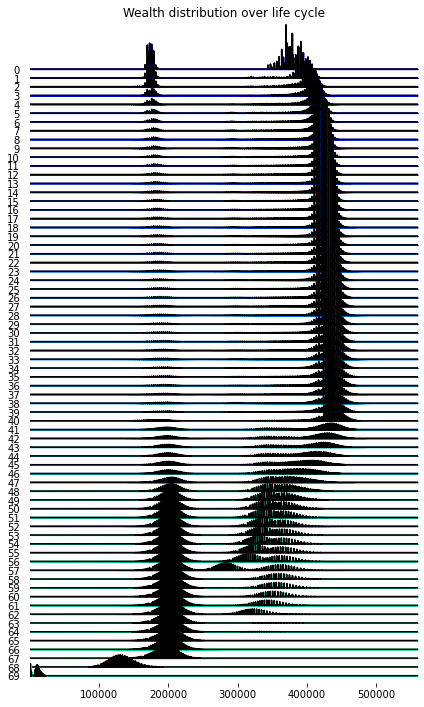

In [43]:
fig, axes = joypy.joyplot(ap_pdfs_life, 
                          kind="values", 
                          x_range=ap_range,
                          figsize=(6,10),
                          title="Wealth distribution over life cycle",
                         colormap=cm.winter)

#axes[-1].set_xticks(a_values);

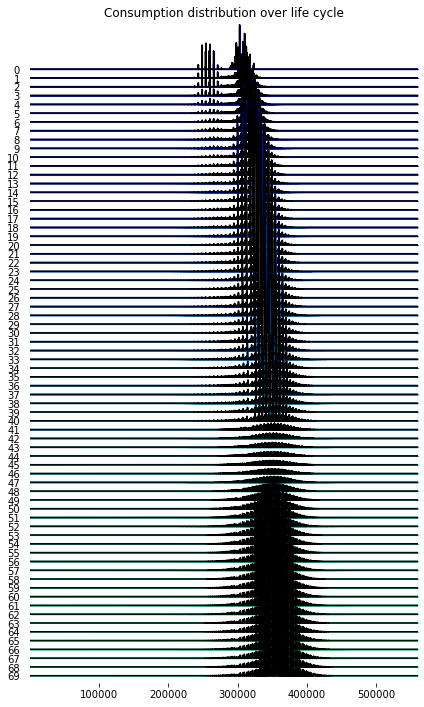

In [44]:
fig, axes = joypy.joyplot(cp_pdfs_life, 
                          kind="values", 
                          x_range=cp_range,
                          figsize=(6,10),
                          title="Consumption distribution over life cycle",
                         colormap=cm.winter)

#axes[-1].set_xticks(a_values);

### General Equilibrium 

In [8]:
def unemp_insurance2tax(μ,
                        ue_fraction):
    """
    under balanced government budget, what is the tax rate on income corresponds to the ue benefit μ
    (1-ue_fraction)x tax + ue_fraction x mu x tax = ue_fraction x mu 
    --> tax = (ue_fraction x mu)/(1-ue_fraction)+ue_fraction x mu
    """
    num = (ue_fraction*μ)
    dem = (1-ue_fraction)+(ue_fraction*μ)
    return num/dem

In [9]:
## needs to test this function 

def SS2tax(SS, ## social security /pension replacement ratio 
           T,  ## retirement years
           age_dist,  ## age distribution in the economy 
           G,         ## permanent growth fractor lists over cycle
           emp_fraction):  ## fraction of employment in work age population 
    pic_share = np.cumprod(G)  ## generational permanent income share 
    pic_age_share = np.multiply(pic_share,
                               age_dist)  ## generational permanent income share weighted by population weights
    
    dependence_ratio = np.sum(pic_age_share[T:])/np.sum(pic_age_share[:T-1]*emp_fraction)
    ## old dependence ratio 
    
    λ_SS = SS*dependence_ratio 
    ## social security tax rate on labor income of employed 
    
    return λ_SS

In [10]:
#economy_data = [
#    ('Z', float64),            
#    ('K', float64),             
#    ('L',float64),              
#    ('α',float64),           
#    ('δ',float64)
#]

In [11]:
#@jitclass(economy_data)
class Economy:
    ## An economy class that saves market and production parameters 
    
    def __init__(self,
             Z = 1.00,     
             K = 1.00, 
             L = 1.00,
             α = 0.33, 
             δ = 0.025,     
             ):  
        self.Z = Z
        self.K = K
        self.L = L
        self.α = α
        self.δ = δ
        
    def KY(self):
        return (self.K/self.Y())
    
    def Y(self):
        return self.Z*self.K**self.α*self.L**(1-self.α)
    
    def YL(self):
        return self.Z*(1-self.α)*(self.K/self.L)**self.α
    
    def YK(self):
        return self.Z*self.α*(self.L/self.K)**(1-self.α)
    
    def R(self):
        return 1+self.YK()-self.δ

In [13]:
from scipy.optimize import fsolve

CDEconomy = Economy()

KY_ratio_target = 3
W_target = 1.0
N_ss = 0.9

def distance(ZK):
    CDEconomy.N = N_ss
    CDEconomy.Z,CDEconomy.K = ZK
    distance1 = CDEconomy.KY()- KY_ratio_target
    distance2 = CDEconomy.YL()- W_target 
    return [distance1,distance2]

Z_root,K_root = fsolve(distance,
                       [0.7,0.5])

print('Normalized Z',Z_root)
print('Normalized K',K_root)

CDEconomy.Z,CDEconomy.K = Z_root,K_root

W_fake = CDEconomy.YL()
KY_fake = CDEconomy.KY()
R_fake = CDEconomy.R()

print('W',W_fake)
print('KY',KY_fake)
print('R',R_fake)

Normalized Z 0.9100806239574033
Normalized K 4.477611940298525
W 1.0000000000000009
KY 3.0000000000000084
R 1.0849999999999997


In [51]:
## stationary asset demand for a given capital stock/factor price

def StE_K_d(model,
            K_s,
            dstn):  ## distribution between emp and unemp 
    """
    Given a proposed capital stock/asset supply and initial wealth from accidental bequests,
    this function generates the stationary asset demands, and resulting accidental bequests 

    """
    ################################
    ## Step 0. Parameterize the model 
    ################################
    ## get the L based on current employed fraction
    uemp_now,emp_now = dstn[0],dstn[1]
    print('Labor force',str(emp_now))
    
    
    ## obtaine factor prices from FOC of firms 
    #print(K_s)
    #print(nb.typeof(K_s))
    one_economy = Economy(Z = Z_root,
                          K = K_s,
                          L = emp_now)
    #print(nb.typeof(one_economy.K))
    print('Capital stock',str(K_s))
    W,R = one_economy.YL(),one_economy.R()
    print('Wage rate',str(W))
    print('Real interest rate',str(R))
    ##################################
    model.W, model.R = W,R
    ##################################
    
    ## stable age distribution 
    age_dist = stationary_age_dist(model.L,
                                   n = 0.0,
                                   LivPrb =model.LivPrb)
    
    ## obtain tax rate from the government budget balance 
    
    model.λ = unemp_insurance2tax(model.unemp_insurance,
                                 uemp_now)
    print('Tax rate',str(model.λ))
    
    ## obtain social security rate balancing the SS replacement ratio 
    
    model.λ_SS = SS2tax(model.pension, ## social security /pension replacement ratio 
                        model.T,  ## retirement years
                        age_dist,  ## age distribution in the economy 
                        model.G,         ## permanent growth fractor lists over cycle
                        emp_now)
  
    print('Social security tax rate',str(model.λ_SS))

    ################################
    ## Step 1. Solve the model 
    ################################

    ## terminal period solution
    k = len(model.s_grid)
    k2 =len(model.eps_grid)
    n = len(model.P)

    σ_init = np.empty((k,k2,n))
    a_init = np.empty((k,k2,n))

    # terminal solution c = m 
    for z in range(n):
        for j in range(k2):
            a_init[:,j,z] = 2*model.s_grid
            σ_init[:,j,z] = a_init[:,j,z] 

    ## solve the model 
    as_star, σs_star = solve_model_backward_iter(model,
                                                 a_init,
                                                 σ_init)
    
    ################################
    ## Step 2. StE distribution
    ################################


    ## accidental transfers 
    #model.init_b = init_b
    
    ## Get the StE K_d
    ## get the transition matrix and policy grid 
    
    m_dist_grid_list,p_dist_grid_list = define_distribution_grid(model,
                                                             num_pointsM = n_m,
                                                             num_pointsP = n_p)

    tran_matrix_lists, dist_lists,mp_pdfs_2d_lists,mp_pdfs_lists,cp_PolGrid_list,ap_PolGrid_list = SSDist(model,
                                                                                                          as_star,
                                                                                                          σs_star,
                                                                                                          m_dist_grid_list,
                                                                                                        p_dist_grid_list)    
    
    
    A = Aggregate(ap_PolGrid_list,
                  mp_pdfs_2d_lists,
                  ss_dstn,
                  age_dist)
    
    K_d = A*model.W  ## no population growth otherwise diluted by (1+n)
    
    ## realized accidental transfers from age 2 to L
    
    #ap_PolGrid_list_old = [ap_PolGrid_list[0][1:],ap_PolGrid_list[1][1:]]
    #mp_pdfs_2d_lists_old = [mp_pdfs_2d_lists[0][1:],mp_pdfs_2d_lists[1][1:]]
    #age_dist_old =  age_dist[1:]
    #A_old = Aggregate(ap_PolGrid_list_old,
    #                  mp_pdfs_2d_lists_old,
    #                  ss_dstn,
    #                 age_dist_old)*model.W 
    
    #init_b_out = model.bequest_ratio*(1-model.LivPrb)*A_old*(1-age_dist[0])*model.R/age_dist[0]
    
    print('Induced capital stock',str(K_d))
    #print('Induced  bequest',str(init_b_out))
    
    return K_d

In [52]:
## function to solve the equilibrium 
eq_func = lambda K: StE_K_d(model=lc_mkv,
                            K_s = K,
                            dstn=ss_dstn)

In [53]:
## solve the fixed point 

K_eq = op.fixed_point(eq_func,
                      x0 = 2.0)

Labor force 0.7500000000000001
2.0
array(float64, 0d, C)
array(float64, 0d, C)
Capital stock 2.0
Wage rate 0.7507048105215517
Real interest rate 1.113656298958272
Tax rate 0.04761904761904759
Social security tax rate 0.20251142361030447
time taken:77.33303713798523
Induced capital stock 3.8156008704561337
Labor force 0.7500000000000001
3.8156008704561337
float64
float64
Capital stock 3.8156008704561337
Wage rate 0.9290627980318117
Real interest rate 1.0649461402192493
Tax rate 0.04761904761904759
Social security tax rate 0.20251142361030447
time taken:77.47640204429626
Induced capital stock 3.0073594475668806
Labor force 0.7500000000000001
3.256327992410766
array(float64, 0d, C)
array(float64, 0d, C)
Capital stock 3.256327992410766
Wage rate 0.8817177572770838
Real interest rate 1.075023453500557
Tax rate 0.04761904761904759
Social security tax rate 0.20251142361030447
time taken:77.23156404495239
Induced capital stock 3.2386408980902814
Labor force 0.7500000000000001
3.238640898090281

In [54]:
## get the StE 
ss_dstn = cal_ss_2markov(lc_mkv.P)
L_ss = ss_dstn[1]

## compute factor prices in StE
one_economy = Economy(K=K_eq,
                      L=L_ss)
print('SS Capital stock',str(K_eq))
W_eq,R_eq = one_economy.YL(),one_economy.R()
print('SS Wage Rate',str(W_eq))
print('SS Real interest rate',str(R_eq))

## get the distribution under SS
lc_mkv.W,lc_mkv.R = W_eq,R_eq

## solve the model again 

## terminal period solution
k = len(lc_mkv.s_grid)
k2 =len(lc_mkv.eps_grid)
n = len(lc_mkv.P)

σ_init = np.empty((k,k2,n))
a_init = np.empty((k,k2,n))

# terminal solution c = m 
for z in range(n):
    for j in range(k2):
        a_init[:,j,z] = 2*lc_mkv.s_grid
        σ_init[:,j,z] = a_init[:,j,z] 

as_star, σs_star = solve_model_backward_iter(lc_mkv,
                                             a_init,
                                             σ_init)

## get the transition matrix and policy grid 

tran_matrix_lists, dist_lists,mp_pdfs_2d_lists,mp_pdfs_lists,cp_PolGrid_list,ap_PolGrid_list = SSDist(lc_mkv,
                                                                                                      as_star_mkv,
                                                                                                      σs_star_mkv,
                                                                                                      m_dist_grid_list,
                                                                                                      p_dist_grid_list)


## flatten the distribution of a and its corresponding pdfs 


ap_grid_dist, ap_pdfs_dist = faltten_dist(ap_PolGrid_list,
                                        mp_pdfs_2d_lists,
                                        ss_dstn,
                                        age_dist)


cp_grid_dist, cp_pdfs_dist = faltten_dist(cp_PolGrid_list,
                                        mp_pdfs_2d_lists,
                                        ss_dstn,
                                        age_dist)


SS Capital stock 3.2443131951366064
SS Wage Rate 1.0863633379717224
SS Real interest rate 1.0986951662139057
time taken:77.06680679321289


(0.0, 1.0)

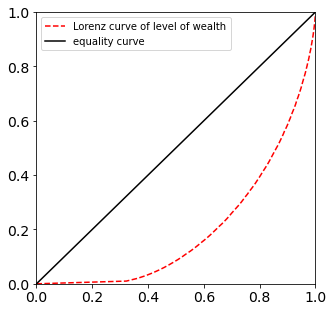

In [55]:
## compute things needed for lorenz curve plot of asset accumulation 

share_agents_ap, share_ap = lorenz_curve(ap_grid_dist,
                                     ap_pdfs_dist,
                                     nb_share_grid = 100)


## Lorenz curve of steady state wealth distribution

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(share_agents_ap,share_cp, 'r--',label='Lorenz curve of level of wealth')
ax.plot(share_agents_ap,share_agents_ap, 'k-',label='equality curve')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_44509/1570813690.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ap_grid_dist),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_44509/1570813690.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ap_grid_dist),


Text(0, 0.5, '$prob(a)$')

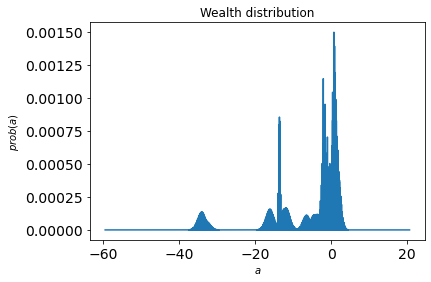

In [56]:
## Wealth distribution 

plt.title('Wealth distribution')
plt.plot(np.log(ap_grid_dist), 
         ap_pdfs_dist)
plt.xlabel(r'$a$')
plt.ylabel(r'$prob(a)$')

Text(0, 0.5, '$prob(a)$')

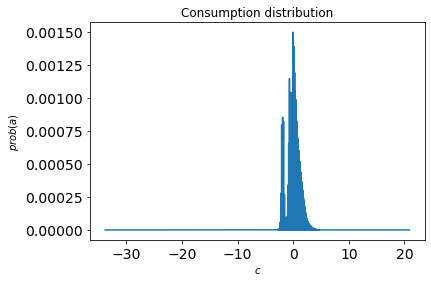

In [57]:
## Consumption distribution 
plt.title('Consumption distribution')
plt.plot(np.log(cp_grid_dist), 
         cp_pdfs_dist)
plt.xlabel(r'$c$')
plt.ylabel(r'$prob(a)$')

In [58]:
## Life cycle wealth profile 

## xxxxxx

### Consumption Jacobians



In [ ]:
# a test to see if its stable


Ce =[]
Cu =[]
Cagg =[]
Aagg =[]

for i in range(20):
    for k in range(lc_mkv(T)):
        dstne = mp_pdfs_lists_e[k]
        dstnu = mp_pdfs_lists_u[k]
        
        Ae = np.dot(example.aPol_Grid_e,dstne)
        Au = np.dot(example.aPol_Grid_u,dstnu)
    
    Ce.append(np.dot(example.cPol_Grid_e,dstne))
    Cu.append(np.dot(example.cPol_Grid_u,dstnu))
    
    Cagg.append(np.dot(example.cPol_Grid_e,dstne)* example.prb_emp + example.prb_unemp*np.dot(example.cPol_Grid_u,dstnu))
    Aagg.append(Ae* example.prb_emp +  Au*example.prb_unemp)
    
    dstne = np.dot(example.tran_matrix_e,dstne)
    dstnu = np.dot(example.tran_matrix_u,dstnu)

In [ ]:
##
#plt.plot(Cagg)
#plt.show()
#print('Aggregate Consumption = ' +str(Cagg[10]))

#plt.plot(Aagg)
#plt.show()
#print('Aggregate Asset = ' +str(Aagg[10]))

In [ ]:
plt.plot(example.dist_mGrid,steady_Dstn, label = 'all')
plt.plot(example.dist_mGrid,dstne, label = 'employed')
plt.plot(example.dist_mGrid,dstnu, label = 'unemployed')
plt.title('permanent income weighted distribution')
plt.legend()
plt.show()

In [ ]:

class JAC_agent(HANK_SAM_agent):

    
    def update_solution_terminal(self):
        """
        Update the terminal period solution.  This method should be run when a
        new AgentType is created or when CRRA changes.
        Parameters
        ----------
        none
        Returns
        -------
        none
        """
        #IndShockConsumerType.update_solution_terminal(self)

        # Make replicated terminal period solution: consume all resources, no human wealth, minimum m is 0
        StateCount = self.MrkvArray[0].shape[0]
        self.solution_terminal.cFunc = example.solution[0].cFunc
        self.solution_terminal.vFunc = example.solution[0].vFunc
        self.solution_terminal.vPfunc = example.solution[0].vPfunc
        self.solution_terminal.vPPfunc = example.solution[0].vPPfunc
        self.solution_terminal.mNrmMin = np.zeros(StateCount)
        self.solution_terminal.hRto = np.zeros(StateCount)
        self.solution_terminal.MPCmax = np.ones(StateCount)
        self.solution_terminal.MPCmin = np.ones(StateCount)
        
    def check_markov_inputs(self):
        """
        Many parameters used by MarkovConsumerType are arrays.  Make sure those arrays are the
        right shape.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        StateCount = self.MrkvArray[0].shape[0]



# Jacobian
params = deepcopy(HANK_SAM_Dict)
params['T_cycle'] = 100
params['LivPrb']= params['T_cycle']*example.LivPrb
params['PermGroFac']=params['T_cycle']*example.PermGroFac
params['PermShkStd'] = params['T_cycle']*example.PermShkStd
params['TranShkStd']= params['T_cycle']*example.TranShkStd
params['Rfree'] = params['T_cycle']*[rfree]
params['MrkvArray'] = params['T_cycle']*example.MrkvArray

# ghost

ghost = JAC_agent(**params)
ghost.IncShkDstn = params['T_cycle']*example.IncShkDstn
ghost.del_from_time_inv('Rfree')
ghost.add_to_time_vary('Rfree')
ghost.dstn_0 = ss_dstn
ghost.cycles = 1

ghost.wage = 1.2
ghost.unemp_insurance = params['T_cycle']*[example.unemp_insurance]
ghost.job_find = params['T_cycle']*[example.job_find]
ghost.job_sep = params['T_cycle']* [example.job_sep]

ghost.solve()




ghost.define_distribution_grid(dist_pGrid = params['T_cycle']*[np.array([1])])
ghost.calc_transition_matrix(params['T_cycle']*[IncShkDstn_ntrl_msr_e])


Agg_Cg =[]
Agg_Ag =[]
Agg_ceg =[]
Agg_cug =[]

Agg_aeg =[]
Agg_aug =[]

dstne = ergodic_distre
dstnu = ergodic_distru
for i in range(ghost.T_cycle):
    
    Ae = np.dot(ghost.aPol_Grid_e[i],dstne)
    Au = np.dot(ghost.aPol_Grid_u[i],dstnu)
    Agg_aeg.append(Ae)
    Agg_aug.append(Au)
    
    Ce = np.dot(ghost.cPol_Grid_e[i],dstne)
    Cu = np.dot(ghost.cPol_Grid_u[i],dstnu)
    Agg_ceg.append(Ce)
    Agg_cug.append(Cu)
    
    Agg_Ag.append(Ae* ghost.prb_emp[i] + Au*ghost.prb_unemp[i])
    Agg_Cg.append(Ce* ghost.prb_emp[i] + Cu*ghost.prb_unemp[i])
    
    dstne = np.dot(ghost.tran_matrix_e[i],dstne)
    dstnu = np.dot(ghost.tran_matrix_u[i],dstnu)



#--------------------------------------------------------------------
#jacobian executed here

example2 = JAC_agent(**params)
dx = -.0001




#example2.Rfree = q*[rfree] + [rfree + dx] + (params['T_cycle'] - q )*[rfree]

example2.cycles = 1

example2.wage = example.wage

example2.unemp_insurance = params['T_cycle']*[example.unemp_insurance]

#example2.job_find = params['T_cycle']*[example.job_find]
example2.job_sep = params['T_cycle']* [example.job_sep]
example2.IncShkDstn = params['T_cycle']*[ [employed_IncShkDstn, unemployed_IncShkDstn] ]
example2.del_from_time_inv('Rfree')
example2.add_to_time_vary('Rfree')
example2.dstn_0 = ss_dstn

MrkvArray_dx = np.array( [ [1 - job_sep*(1-(job_find + dx)) , job_find + dx] ,  #" The sum of entries in each column in t should equal one. "
                          
                               [job_sep*(1- (job_find +dx) ), 1 -( job_find+dx) ] ]  ).T


CHist=[]
AHist=[]

test_set =[30]
#for q in range(params['T_cycle']):
    
for q in test_set:
    
    example2.MrkvArray = q*example.MrkvArray + [MrkvArray_dx] + (params['T_cycle'] - q )*example.MrkvArray
    
    example2.job_find =    q*[example.job_find] + [example.job_find + dx]+ (params['T_cycle'] - q )*[example.job_find] 
    
    example2.solve()


    start = time.time()

    example2.define_distribution_grid(dist_pGrid = params['T_cycle']*[np.array([1])])
    example2.calc_transition_matrix(params['T_cycle']*[IncShkDstn_ntrl_msr_e])
    
    print('seconds past : ' + str(time.time()-start))
    
    Agg_C =[]
    Agg_A =[]
    dstne = ergodic_distre
    dstnu = ergodic_distru
    
    Agg_ce =[]
    Agg_cu =[]
    
    Agg_ae =[]
    Agg_au =[]
    
    for i in range(example2.T_cycle):
        
        Ae = np.dot(example2.aPol_Grid_e[i],dstne)
        Au = np.dot(example2.aPol_Grid_u[i],dstnu)
        
        Agg_ae.append(Ae)
        Agg_au.append(Au)
        
        Ce = np.dot(example2.cPol_Grid_e[i],dstne)
        Cu = np.dot(example2.cPol_Grid_u[i],dstnu)
        Agg_ce.append(Ce)
        Agg_cu.append(Cu)
        
        Agg_A.append(Ae* example2.prb_emp[i] + Au*example2.prb_unemp[i])
        Agg_C.append(Ce* example2.prb_emp[i] + Cu*example2.prb_unemp[i])
        
        dstne = np.dot(example2.tran_matrix_e[i],dstne)
        dstnu = np.dot(example2.tran_matrix_u[i],dstnu)



    CHist.append((np.array(Agg_C)-np.array(Agg_Cg))/abs(dx))
    AHist.append((np.array(Agg_A) - np.array(Agg_Ag))/abs(dx))
        
    
    

    

    
plt.plot((np.array(Agg_C)-np.array(Agg_Cg))/abs(dx))
plt.plot(np.zeros(len(Agg_C)))
plt.title('IPR of Aggregate Consumption ')
plt.show()

plt.plot((np.array(Agg_A) - np.array(Agg_Ag))/abs(dx))
plt.plot(np.zeros(len(Agg_A)))
plt.title(' IPR of Aggregate Assets')
plt.show()


plt.plot((np.array(Agg_ce)-np.array(Agg_ceg))/abs(dx))
plt.title('IPR of Employed consumption')
plt.show()
plt.plot((np.array(Agg_cu)-np.array(Agg_cug))/abs(dx))
plt.title('IPR of Unemployed Consumption')
plt.show()

plt.plot((np.array(Agg_ae)-np.array(Agg_aeg))/abs(dx))
plt.title('IPR of Employed Savings')
plt.show()
plt.plot((np.array(Agg_au)-np.array(Agg_aug))/abs(dx))
plt.title('IPR of Unemployed Savings')
plt.show()



fig, axs = plt.subplots(2, 2)
axs[0, 0].plot((np.array(Agg_C)-np.array(Agg_Cg))/abs(dx),'darkgreen' )
axs[0, 0].set_title("IPR of Aggregate Consumption")
axs[1, 0].plot((np.array(Agg_ce)-np.array(Agg_ceg))/abs(dx),'forestgreen' )
axs[1, 0].set_title("IPR of Employed consumption")
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot((np.array(Agg_cu)-np.array(Agg_cug))/abs(dx), 'forestgreen')
axs[0, 1].set_title("IPR of Unemployed Consumption")
fig.tight_layout()



fig, axs = plt.subplots(2, 2)
axs[0, 0].plot((np.array(Agg_A)-np.array(Agg_Ag))/abs(dx),'darkgreen' )
axs[0, 0].set_title("IPR of Aggregate Savings")
axs[1, 0].plot((np.array(Agg_ae)-np.array(Agg_aeg))/abs(dx),'forestgreen' )
axs[1, 0].set_title("IPR of Employed Savings")
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot((np.array(Agg_au)-np.array(Agg_aug))/abs(dx), 'forestgreen')
axs[0, 1].set_title("IPR of Unemployed Savings")
fig.tight_layout()

# -


In [ ]:

# ## Old codes: simulate a cross-sectionl history 

#@njit
def simulate_time_series(lc, σ, z_idx_seq, p_income,T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.
    * z_seq is a time path for {Z_t} recorded by index, instead of its numeric value

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c  = np.empty_like(a)
    #c1 = np.empty_like(a)
    #c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = lc.R
    z_val = lc.z_val ## values of the state 
    
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z_idx = z_idx_seq[t]
        z = z_val[z_idx]    
        Y = lc.Y(z, η_sim[t])
        c[t] = σ(a[t], z_idx)
        #c1[t],c2[t] = allocate(c[t], S = S) 
        #if t<T-1:
        #    a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c[t]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c

def simulate_time_series_new(lc, σ, z_seq, p_income, T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t} recorded by its numeric value (different from the previous function)

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c = np.empty_like(a)
    #c1 = np.empty_like(a)
    #c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = lc.R
    #z_val = ifp.z_val ## values of the state 
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z = z_seq[t] ## z values
        S = lc.ϕ(z,ζ_sim[t])
        Y = lc.Y(z, η_sim[t])
        c[t] = σ(a[t], z)
        #c1[t],c2[t] = allocate(c[t], S = S) 
        #if t<T-1:
        #    a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c[t]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c

## now, we simulate the time-series of a cross-sectional matrix of N agents 

#@njit
def simulate_distribution(lc, 
                          a_star, 
                          p_vec, 
                          σ_star,
                          z_mat, 
                          p_income_mat,
                          N = 3000, 
                          T = 400,
                          discrete = True):
    N_z, T_z = z_mat.shape
    
    assert N_z>=N and T_z >=T, 'history of the markov states are smaller than the simulated matrix'
    
    
    z_mat = z_mat[0:N,0:T]
    ## z_mat is a N_sim x T sized matrix that takes the simulated Markov states 
    a_mat = np.empty((N,T))
    c_mat = np.empty((N,T))
    #c1_mat = np.empty((N,T))
    #c2_mat = np.empty((N,T))
    
    ## get the policy function
    
    if discrete ==True:
        σ = policyfunc(lc,
                       a_star,
                       σ_star,
                       discrete = True)  ## interpolate for discrete z index 
        for i in range (N):
            a_mat[i,:],c_mat[i,:] = simulate_time_series(lc,
                                                         σ,
                                                         z_mat[i,:],
                                                         p_income_mat[i,:],
                                                         T = T)
    else:
        σ = policyfunc(lc,
                       a_star,
                       σ_star,
                       discrete = False) ## interpolate for continous z value 
        for i in range (N):
            a_mat[i,:],c_mat[i,:]= simulate_time_series_new(lc,
                                                            σ,
                                                            z_mat[i,:],
                                                            p_income_mat[i,:],
                                                            T = T)
            
    ## multiply permanent income level 
    #c_mat= np.multiply(c_mat,p_income_mat)
    #c1_mat = np.multiply(c1_mat,p_income_mat)
    #c2_mat = np.multiply(c2_mat,p_income_mat)
    #a_mat = np.multiply(a_mat,p_income_mat) 

    return a_mat,c_mat

# + code_folding=[0]
## simulate a Markov sequence 

mc = MarkovChain(lc.P)

### Simulate history of Idiosyncratic Z states 
#### (For Z to be aggregate state. We can directly copy Z for different agents) 

## number of agents 

N = 1000
T = 25        ## simulated history of time period

z_idx_ts = mc.simulate(T, random_state=13274)
z_idx_mat = np.tile(z_idx_ts,(N,1))


# + code_folding=[3]
## simulate a permanent income distributions 

@njit
def PerIncSimulate(T,
               sigma,
               init = 0.001):
    pshk_draws = sigma*np.random.randn(T)-sigma**2/2
    log_p_inc = np.empty(T)
    log_p_inc[0] = init
    for t in range(T-1):
        log_p_inc[t+1] = log_p_inc[t]+ pshk_draws[t+1]
    p_income = np.exp(log_p_inc)
    return p_income

## simulate histories of permanent income 

p_income_mat = np.empty((N,T))

for n in range(N):
    p_income_mat[n,:] = PerIncSimulate(T,
                                       sigma = lc.sigma_n,
                                       init = 0.0001)

# + code_folding=[]
## Simulate the distribution of consumption/asset (perfect understanding)
as_star = as_stars[0]
σs_star = σs_stars[0]

p_vec = (1,1) 
a_dist,c_dist = simulate_distribution(lc,
                                      as_star,
                                      p_vec,
                                      σs_star,
                                      z_idx_mat,
                                      p_income_mat,
                                      N = N,
                                      T = T,
                                      discrete = True)

# + code_folding=[]
## aggregate history 

co_mat = np.multiply(c_dist,p_income_mat)  ## non-normalized consumption
lco_mat = np.log(co_mat)
lco_av = np.mean(lco_mat,axis = 0)

#p_av =  np.mean(p_income_mat,axis = 0)  
#lp_av = np.log(p_av)
lp_income_mat = np.log(p_income_mat)   ## permanent income level 
lp_av = np.mean(lp_income_mat,axis = 0)

#c_av = np.mean(c_dist,axis=0)
#lc_av = np.log(c_av)
lc_mat = np.log(c_dist)             ## normalized consumption
lc_av = np.mean(lc_mat,axis = 0) 

lc_sd = np.sqrt(np.diag(np.cov(lc_mat.T)))
# -

plt.title('average log consumption (normalized)')
plt.plot(lc_av[1:],label = r'$\widebar{ln(c/o)}$')
plt.legend(loc=2)